In [1]:
!git clone https://github.com/btubay/techsummitCoEIA.git

Cloning into 'techsummitCoEIA'...
remote: Enumerating objects: 20850, done.
remote: Counting objects: 100% (20850/20850), done.
remote: Compressing objects: 100% (20839/20839), done.
remote: Total 20850 (delta 24), reused 20810 (delta 7), pack-reused 0
Receiving objects: 100% (20850/20850), 32.56 MiB | 17.37 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [2]:
import os
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [3]:
# General parameters
batch_size = 128
epochs = 30
pic_size = 48
folder_path = "techsummitCoEIA/images/"

In [4]:
def scan_data(folder_path):
    mydict = dict()
    for (root,dirs,files) in os.walk(folder_path, topdown=False):
        if len(files)>0:
            mydict[root.split('/')[-1]]=len(files)
    return(mydict)
    
def plot_dist(my_dict, data):
    fig = px.bar(x=my_dict.values(),
             y=my_dict.keys(),
             orientation='h',
             color=my_dict.values(),
             title=data + ' Distribution',
             opacity=0.8,
             color_discrete_sequence=px.colors.diverging.curl,
             template='plotly_dark'
            )
    fig.update_xaxes()
    fig.show()

def plot_exp(expression):
    plt.style.use('dark_background')
    plt.figure(figsize= (12,12))
    for i in range(1, 10, 1):
        plt.subplot(3,3,i)
        img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img)   
    plt.show()

In [5]:
train_dict = scan_data(folder_path + "train/")
test_dict = scan_data(folder_path + "test/")
print(train_dict)
print(test_dict)

{'happy': 6447, 'neutral': 4483, 'sad': 4444}
{'happy': 1825, 'neutral': 1216, 'sad': 1139}


In [6]:
plot_dist(train_dict, "Training data")

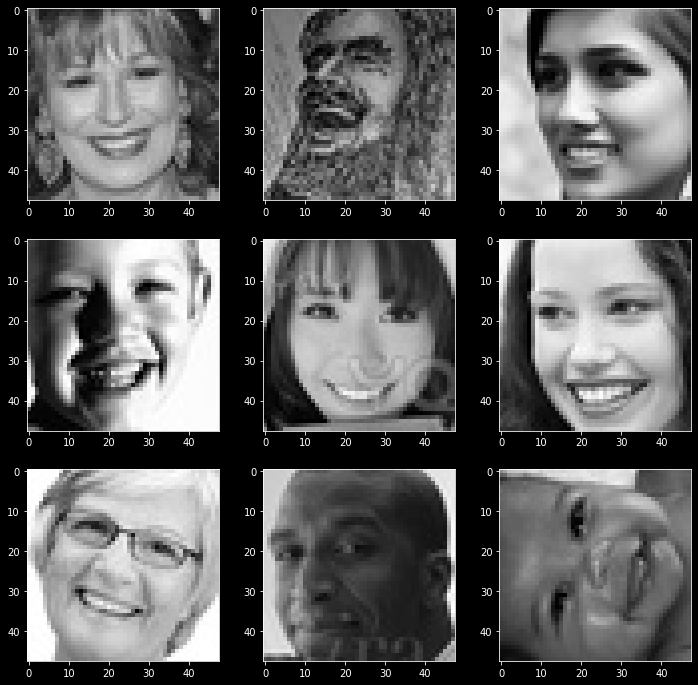

In [7]:
# Plot samples expression
plot_exp('happy')

In [8]:
# Generate train and validation data

datagen_train  = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)


train_set = datagen_train.flow_from_directory(
        folder_path+"train",
        target_size=(pic_size, pic_size),
        color_mode = "grayscale",
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

validation_set = datagen_val.flow_from_directory(
        folder_path+"validation",
        target_size=(pic_size, pic_size),
        color_mode = "grayscale",
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

test_set = datagen_val.flow_from_directory(
        folder_path+"test",
        target_size=(pic_size, pic_size),
        color_mode = "grayscale",
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

labels = (train_set.class_indices)
values2labels= {v: k for k, v in labels.items()}   
print(labels)               
print(values2labels)

Found 15374 images belonging to 3 classes.
Found 1710 images belonging to 3 classes.
Found 4180 images belonging to 3 classes.
{'happy': 0, 'neutral': 1, 'sad': 2}
{0: 'happy', 1: 'neutral', 2: 'sad'}


## Diseño de la red

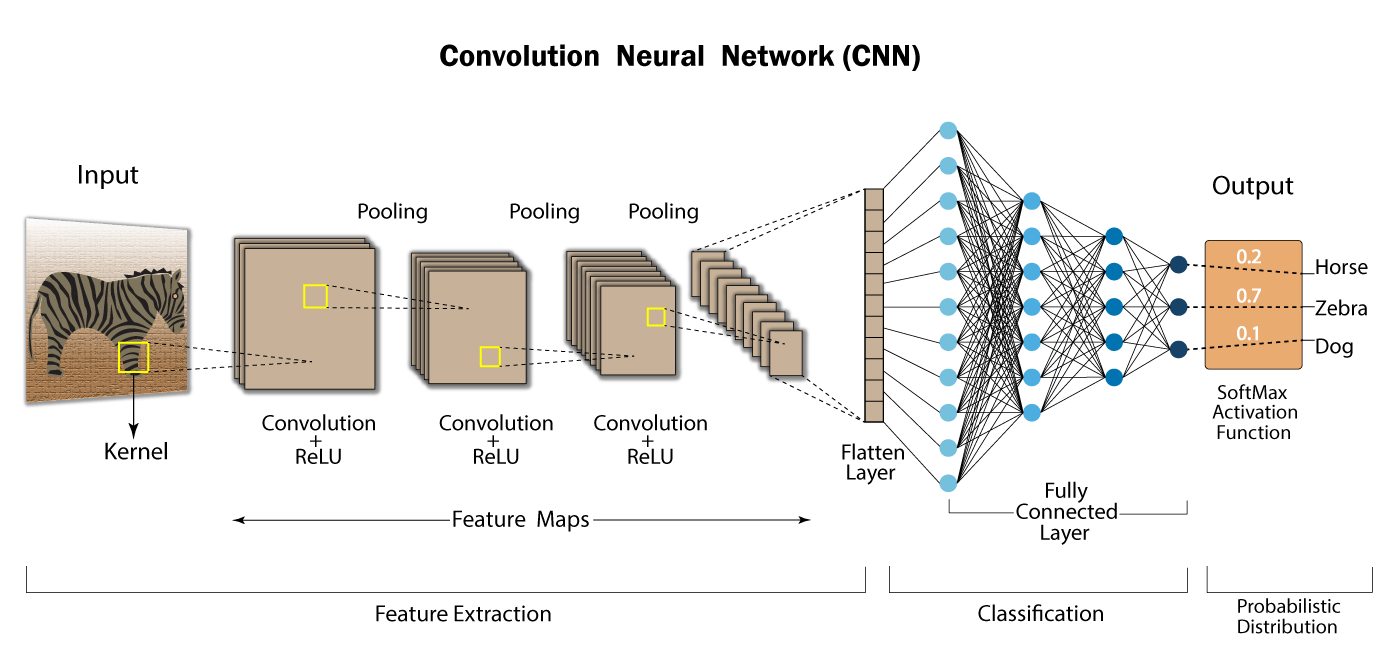

### Principios de diseño para una red neuronal convolucional:

 "*Mantener el espacio de características amplio y poco profundo en las etapas iniciales de la red, y hacerlo más estrecho y profundo hacia el final*"

1.	**Empezar** siempre utilizando **filtros más pequeños** para recoger la mayor cantidad de información local posible, y luego **aumentar gradualmente la anchura del filtro** para reducir la anchura del espacio de características generado para representar información más global, de alto nivel y representativa.
2.	Siguiendo el principio, el **número de canales debe ser bajo al principio**, de manera que detecte características de bajo nivel que se combinen para formar muchas formas complejas (aumentando el número de canales) que ayuden a distinguir entre clases.
3.	Los **tamaños generales de los filtros utilizados son 3x3, 5x5 y 7x7** para la capa convolucional para imágenes de tamaño moderado o pequeño y para los parámetros de **Max-Pooling utilizamos tamaños de filtro de 2x2 o 3x3 con un stride de 2**. Se pueden utilizar tamaños de filtro y strides más grandes para reducir una imagen grande a un tamaño moderado y luego ir más allá con la convención indicada.
4.	Utilizar el **padding = ‘same’** cuando considere que los bordes de la imagen pueden ser importantes o simplemente para ayudar a alargar la arquitectura de red, ya que el relleno mantiene las mismas dimensiones incluso después de la operación de convolución y, por lo tanto, puede realizar más convoluciones sin reducir el tamaño.
5.	**Añadir capas hasta que haya overfitting**. Ya que una vez que logramos una precisión considerable en nuestro conjunto de validación podemos utilizar componentes de regularización como la **regularización l1/l2**, el **dropout**, **batch norm**, la **data-aumentation**, etc. para reducir el overfitting.
6.	Usar **redes clásicas** como **LeNet**, **AlexNet**, **VGG-16**, **VGG-19**, etc. como inspiración al construir las arquitecturas de sus modelos. Es decir, seguir la tendencia utilizada en las arquitecturas, por ejemplo, la tendencia en las capas Conv-Pool-Conv-Pool o Conv-Conv-Pool-Conv-Conv-Pool o la tendencia en el número de canales 32-64-128 o 32-32-64-64 o la tendencia en los tamaños de los filtros, los parámetros Max-pooling, etc.


In [9]:
def model_cnn(): 

    # building a linear stack of layers with the sequential model
    model = Sequential()

    ## Feature extraction -> Convolutional and pooling layers
    model.add(Conv2D(8, kernel_size=(3,3), padding='same', activation='relu', input_shape=(pic_size,pic_size,1)))
    model.add(MaxPool2D(pool_size=(2,2),strides=2))
    model.add(Dropout(0.2))
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides=2))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides=2))
    model.add(Dropout(0.2))
    ## Flatten Layer
    model.add(Flatten())
    ## Classification -> Fully-Connected Layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    ## Output layer
    model.add(Dense(3, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'], loss='categorical_crossentropy')

    model.summary()
    
    return model

In [10]:
#Build model
model_conv = model_cnn()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 16)        0

In [11]:
# Train model
hist = model_conv.fit(train_set, 
                    validation_data = validation_set,
                    epochs = epochs)
model_conv.save("model_facial_expression.h5")

Epoch 1/30
121/121 [==============================] - 17s 41ms/step - loss: 1.0808 - accuracy: 0.4162 - val_loss: 1.0893 - val_accuracy: 0.4433
Epoch 2/30
121/121 [==============================] - 4s 37ms/step - loss: 1.0360 - accuracy: 0.4659 - val_loss: 0.9743 - val_accuracy: 0.5468
Epoch 3/30
121/121 [==============================] - 4s 37ms/step - loss: 0.9581 - accuracy: 0.5330 - val_loss: 0.9173 - val_accuracy: 0.5702
Epoch 4/30
121/121 [==============================] - 4s 37ms/step - loss: 0.9139 - accuracy: 0.5629 - val_loss: 0.8754 - val_accuracy: 0.6035
Epoch 5/30
121/121 [==============================] - 5s 38ms/step - loss: 0.8842 - accuracy: 0.5842 - val_loss: 0.8449 - val_accuracy: 0.6187
Epoch 6/30
121/121 [==============================] - 5s 38ms/step - loss: 0.8561 - accuracy: 0.5979 - val_loss: 0.8148 - val_accuracy: 0.6234
Epoch 7/30
121/121 [==============================] - 5s 38ms/step - loss: 0.8407 - accuracy: 0.6059 - val_loss: 0.8067 - val_accuracy: 0.620

[]

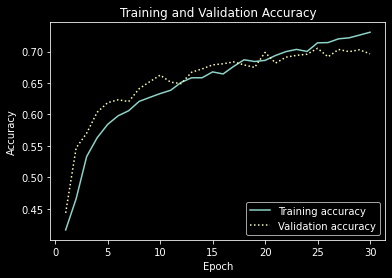

In [12]:
# Training and Validation Accuracy
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [13]:
# Predict test set
y_predicted = model_conv.predict(test_set)
y_pred = [np.argmax(probas) for probas in y_predicted]
y_test = test_set.classes

33/33 [==============================] - 1s 34ms/step


Accuracy: 0.7050239234449761
Precision: 0.7072569890106946
F1-score: 0.7056126292285366
Recall: 0.7050239234449761



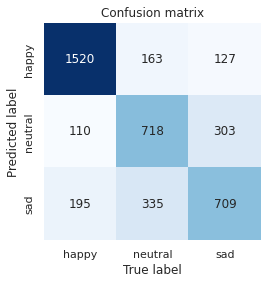

In [14]:
# Metrics
sns.set()
mat = confusion_matrix(y_pred, y_test)
s = sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', xticklabels = ['happy', 'neutral', 'sad'], yticklabels = ['happy', 'neutral', 'sad'])
plt.title("Confusion matrix")
s.set(xlabel='True label', ylabel='Predicted label')
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred, average='weighted')))
print("F1-score: " + str(f1_score(y_test, y_pred, average='weighted')))
print("Recall: " + str(recall_score(y_test, y_pred, average='weighted')) + "\n")

In [15]:
# Load image
my_image = load_img('techsummitCoEIA/persona_feliz.jpg', target_size=(pic_size, pic_size), color_mode="grayscale")

# Preprocess image
my_image = img_to_array(my_image)
my_image = np.array([my_image])

# Predict
prediction = model_conv.predict(my_image)
print(prediction)
print(values2labels[prediction.argmax()])

1/1 [==============================] - 0s 128ms/step
[[1. 0. 0.]]
happy
